** Import Libraries **

In [1]:
## Import libraries
from ast import literal_eval
import os, glob, pandas as pd
import string, re
import numpy as np
from tqdm import tqdm
from collections import Counter
import numbers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from string import ascii_lowercase
import os 
import glob
import re
import requests
import shutil
import pandas as pd
import time
from nltk import ngrams
from operator import itemgetter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pickle
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()

In [3]:
os.chdir("C://Users//Ruben//Documents//GitHub//dhl-ads//resources")
df = pd.read_csv('total_results.csv')

In [35]:
dfr = pd.DataFrame()

for year in sorted(list(set(df.date.astype(str).str[0:4]))):
    d = df[df.date.astype(str).str[0:4] == year]
    len_tot = len(d)
    t = pd.DataFrame([year, len_tot]).T
    dfr = dfr.append(t)

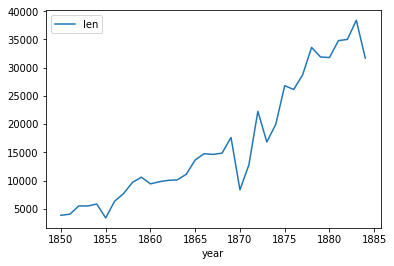

In [36]:
dfr.columns = ['year', 'len']
dfr['year'] = dfr['year'].astype(int)
dfr.plot(x='year', y= ['len'])

** Share of non-na Ads  / Year **

In [37]:
dfr = pd.DataFrame()

for year in sorted(list(set(df.date.astype(str).str[0:4]))):
    d = df[df.date.astype(str).str[0:4] == year]
    len_tot = len(d)
    
    len_nonna = len(d[(d['ex_qual'].astype(str).str[0] == "[") | (d['ex_num'] !=  "na")])
    len_nonna = round(len_nonna / len_tot * 100, 3)
    
    len_qual = len(d[(d['ex_qual'].astype(str).str[0] == "[")])
    len_qual = round(len_qual / len_tot * 100, 3)
    
    len_num = len(d[(d['ex_num'] !=  "na")])
    len_num = round(len_num / len_tot * 100, 3)
    
    t = pd.DataFrame([year, len_nonna, len_qual, len_num]).T
    dfr = dfr.append(t)

In [40]:
dfr.columns = ['year', 'Total Non-NA', 'Qualitative', 'Numerical']
dfr['year'] = dfr['year'].astype(int)

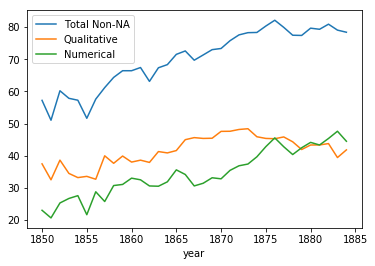

In [41]:
dfr.plot(x='year', y= ['Total Non-NA', 'Qualitative', 'Numerical'])

In [3]:
### Investigate Window Size

In [3]:
def ExtractWindows2(df, list_words, qual_words, window_left, window_right):
    alphabet_id = [c for c in ascii_lowercase] + [c + c for c in ascii_lowercase] + [c + c +c for c in ascii_lowercase]

    opd = dict()
    ctr = 0 # counter for showing progress

    for c,i in enumerate(df.clean):
        set_i = set(i)
        ctr += 1

        if any(e in set_i for e in list_words):     # check if there is an occupation in the advertisement

            occ_list = [o for o in set_i if o in list_words]

            for count,o in enumerate(occ_list):                       # loop over occupations in ad-occupation list and select windows around 'em
                ind = i.index(o)
                sl = i[ind-window_left:ind+window_right]
                sl = ' '.join(sl)
                if 'loon ' in sl or 'salaris' in sl:               # if the word 'loon' is in the window; append [occupation:window] to list (not dictionary because of duplicate occupations)
                    output_list = [o, sl, df['id'][c], df['date'][c], df['image_url'][c], i, ind]
                    opd.update({str(c) + alphabet_id[count]:output_list})

        if ctr % 5000 == 0:                    # print the progress
            print(str(round(ctr / len(df.clean) * 100)) + "%")
    
    
    ## Convert output dictionary to dataframe (for clarity)
    dfa = pd.DataFrame([opd.keys() ,[v[3] for k,v in opd.items()], [v[0] for k,v in opd.items()], [v[1] for k,v in opd.items()],[v[4] for k,v in opd.items()], [' '.join(v[5]) for k,v in opd.items()],[v[6] for k,v in opd.items()],]).T
    dfa.columns = ['id','date', 'oc', 'window','image_url', 'ocr', 'occ_index']
    return dfa

In [4]:
eval_d = dict()

for w in list(range(2,100,2)):
    dfr = ExtractWindows2(d, list_words, qual_words, round(w/2), w)
    l = len(dfr)
    occ = list(dfr['oc'])
    
    eval_d.update({w:[l, occ]})

In [5]:
eval_df = pd.DataFrame()

for i in list(eval_d.keys()):
    k = i
    occ_num = len(eval_d[i][1])
    occ_prod = len(set(eval_d[i][1]))
    
    t = pd.DataFrame([k, occ_num, occ_prod]).T
    eval_df = eval_df.append(t)

In [6]:
eval_df.columns = ['window', 'num_results', 'num_diff_occupations']

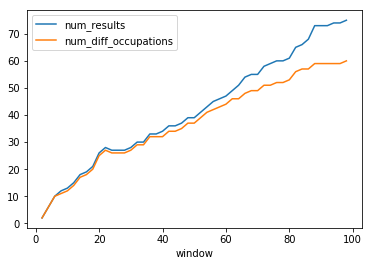

In [7]:
eval_df.plot(x='window', y=['num_results', 'num_diff_occupations'])

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

def PlotDensityWage(df, list_wages, limit):
    list_oc = []
    for o in list_wages:
        subset_oc = df[(df['true_occupation'] == o)]
        l = list(subset_oc[(subset_oc['ex_num'] != 'na') & (subset_oc['ex_num'].astype(str).str.isdigit())]['ex_num'])
        print(str(round(len(l) / len(subset_oc) * 100)) + "% of " + o + " observations has numbers")
        l = [int(x) for x in l if int(x) < limit]
        print("total n=" + str(len(l)))
        list_oc.append(l)
    doc = pd.DataFrame(list_oc).T
    doc.columns = list_wages
    doc.plot.kde(ind=list(range(0,400,10)))

23% of secondant observations has numbers
total n=99
22% of bediende observations has numbers
total n=167
30% of keukenmeid observations has numbers
total n=4657
35% of onderwijzer observations has numbers
total n=641
9% of jufvrouw observations has numbers
total n=15
20% of knecht observations has numbers
total n=91


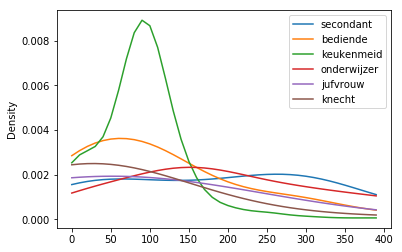

In [34]:
PlotDensityWage(df, ['secondant', 'bediende', 'keukenmeid', 'onderwijzer', 'jufvrouw', 'knecht'], 2000)

In [32]:
def PlotDiaHist(occ, limit):
    list_wage_year = []
    subset_oc = df[(df['true_occupation'] == occ)]

    for y in sorted(list(set(df.date.astype(str).str[0:4]))):
        subset_year = subset_oc[(subset_oc.date.astype(str).str[0:4] == y)]
        l = list(subset_year[(subset_year['ex_num'] != 'na') & (subset_year['ex_num'].astype(str).str.isdigit())]['ex_num'])
        #print(str(round(len(l) / len(subset_year) * 100)) + "% of " + 'keukenmeid' + " observations has numbers")
        l = [int(x) for x in l if int(x) < limit]
        #print("total n=" + str(len(l)))

        #average = sum([int(x) for x in l]) / len(l)
        list_wage_year.append(l)
    list_wage_year = pd.DataFrame(list_wage_year).T
    list_wage_year.columns = [sorted(list(set(df.date.astype(str).str[0:4])))]
    list_wage_year = pd.melt(list_wage_year) 
    list_wage_year.columns = ['per', 'w']
    list_wage_year = list_wage_year.dropna()
    list_wage_year['w'] = list_wage_year['w'].astype(int)
    bp = list_wage_year
    bp['per'] = bp['per'].astype(int)

    sns.set(rc={'figure.figsize':(30,10)})


    ax = sns.boxplot(x="per", y="w", data=bp)

    # Calculate number of obs per group & median to position labels
    medians = bp.groupby(['per'])['w'].median().values
    nobs = bp['per'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
        horizontalalignment='center', size='small', color='w', weight='semibold')

    ax.set(xlabel='Periods (Decades)', ylabel='Wage')
    ax = ax.get_figure()

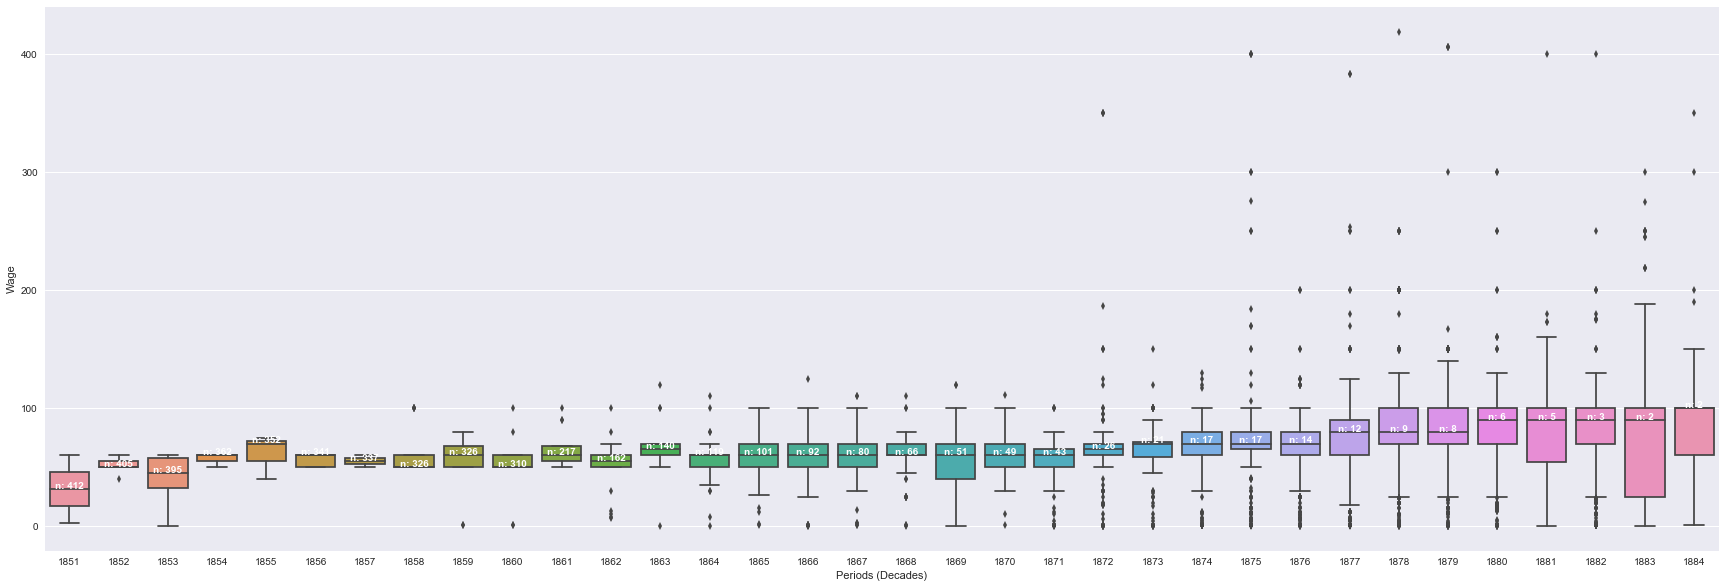

In [36]:
PlotDiaHist('bienstbode', 500)

** Indicator Frequency **

In [11]:
### Indicator Frequency/Year
indicator_year = pd.DataFrame()

for y in sorted(list(set(df.date.astype(str).str[0:4]))):
    subset_year = df[(df.date.astype(str).str[0:4] == y)]
    subset_year = list(subset_year[subset_year['ex_qual'] != "na"]['ex_qual'])
    subset_year = [literal_eval(l) for l in subset_year]
    subset_year = [item for sublist in subset_year for item in sublist]
    t = pd.DataFrame([dict(Counter(subset_year).most_common(10)).keys()]).T
    t.columns = [y]
    indicator_year = pd.concat([indicator_year,t], axis=1)

In [15]:
indicator_year = indicator_year[['1850', '1855','1860','1865','1870','1875','1880','1884']]

In [16]:
indicator_year.to_csv('most_frequent_qual_indicators.csv', index=False)

In [43]:
list_qual = list(df[df['ex_qual'] != "na"]['ex_qual'])
list_qual = [literal_eval(l) for l in list_qual]
list_qual = [item for sublist in list_qual for item in sublist]
qual_counts = dict(Counter(list_qual))

In [44]:
### Stream Graph of Indicator Frequency

sdf_stream_qual = pd.DataFrame()

for year in sorted(list(set(df.date.astype(str).str[0:4]))):
    subset = df[(df.date.astype(str).str[0:4] == year) & (df['ex_qual'] != "na")]

    counted_subset = list(subset[subset['ex_qual'] != "na"]['ex_qual'])
    counted_subset = [literal_eval(l) for l in counted_subset]
    counted_subset = [item for sublist in counted_subset for item in sublist]
    counted_subset = dict(Counter(counted_subset))
    
    list_year = []
    
    for ind in list(qual_counts.keys()):
        if ind not in list(counted_subset.keys()):
            c = 0
            list_year.append(c) 
        else:
            c = counted_subset[ind] / len(subset)
            list_year.append(c)  
            
    list_year = [int(year)] + list_year
    list_year = pd.DataFrame(list_year).T
    sdf_stream_qual = sdf_stream_qual.append(list_year)
    
sdf_stream_qual.columns = ['year'] + list(qual_counts.keys())

In [58]:
import operator
Counter(dict(sdf_stream_qual[list(sdf_stream_qual.columns[1:])].sum(axis=0))).most_common(10)

[('hoog_loon', 7.704321161413208),
 ('naar_bekwaamheid', 6.641309341237001),
 ('goed_loon', 6.528773721194144),
 ('hoog_salaris', 3.015364699143897),
 ('goed_salaris', 2.4783865176938353),
 ('naar_bekwaamheden', 2.079242262700464),
 ('ruim_salaris', 1.9964384245943063),
 ('billijk_salaris', 1.2616551425209497),
 ('zonder_salaris', 1.2045672417382498),
 ('behoorlijk_salaris', 0.9793183575721298)]

(array([1845., 1850., 1855., 1860., 1865., 1870., 1875., 1880., 1885.,
        1890.]), <a list of 10 Text xticklabel objects>)

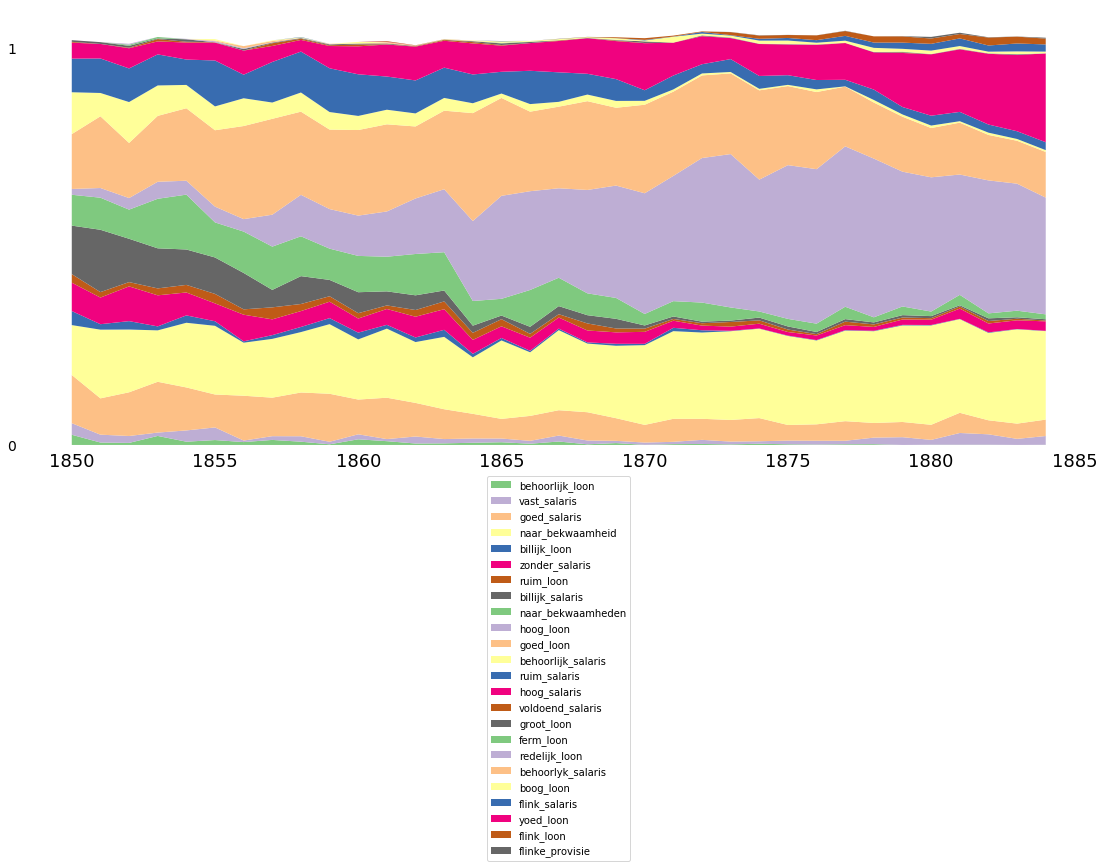

In [48]:
pal = sns.set_palette(sns.color_palette("Accent", 25))


x_lab = "Years"
y_lab = "Share of All Ads w/Qualitative Indicators"
    
fig, ax = plt.subplots(facecolor='white',figsize=(24, 8))
labels = list(sdf_stream_qual.columns[1:])
plt.stackplot(list(sdf_stream_qual.year), *[sdf_stream_qual[col] for col in labels], colors=pal)
ax.set_facecolor("white")
box = ax.get_position()
    #hfont = {'fontname':'Helvetica'}

ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.06))
    
for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
    ticks.set_color("white")
for pos in ['top', 'bottom', 'right', 'left']:
    ax.spines[pos].set_edgecolor("white")
plt.locator_params(integer=True)

plt.yticks(fontsize=14)
plt.xticks(fontsize=18)

#plt.title(title, fontsize=22)

In [22]:
### Investigate Result Rate/Occupation

In [33]:
### Indicator Frequency/Year
occ_year = pd.DataFrame()

for y in sorted(list(set(df.date.astype(str).str[0:4]))):
    subset_year = df[(df.date.astype(str).str[0:4] == y)]
    subset_year = list(subset_year['true_occupation'])
    #subset_year = [literal_eval(l) for l in subset_year]
    #subset_year = [item for sublist in subset_year for item in sublist]
    t = pd.DataFrame([dict(Counter(subset_year).most_common(10)).keys()]).T
    t.columns = [y]
    occ_year = pd.concat([occ_year,t], axis=1)

In [35]:
occ_year[['1850','1855','1860','1865','1870','1875','1880','1884']]

1850           1855             1860           1865  \
0          dkost  boekhandelaar    boekhandelaar  boekhandelaar   
1  boekhandelaar          dkost          pletter        pletter   
2        pletter         lienst            dkost         lienst   
3         lienst           zaar           lienst           hoom   
4           zaar        pletter             ueer     keukenmeid   
5      jbediende       juflrouw             zaar          dkost   
6           ueer      jbediende             hoom           ueer   
7       juflrouw           ueer     borgemeester           zaar   
8      seconöant   huishoudster  hulponderwijzer          koker   
9    onderwijzer           hoom         juflrouw       hniswerk   

            1870           1875           1880           1884  
0        pletter           hoom           zaar           zaar  
1           hoom         lienst           hoom           hoom  
2         lienst  boekhandelaar         lienst         lienst  
3  boekhandelaar        pletter       fetuigen       fetuigen  
4           zaar           zaar     bienstbode        pletter  
5          dkost     bienstbode  boekhandelaar     bienstbode  
6           ueer     keukenmeid        pletter     keukenmeid  
7          koker          koker     keukenmeid  boekhandelaar  
8     bienstbode       fetuigen          koker          dkost  
9     keukenmeid          dkost          dkost          koker